# Ejercicio Covid-19

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Gráficos a nivel mundial

## Preparación general de datos por países

In [2]:
# Datos https://github.com/CSSEGISandData/COVID-19.git
data = pd.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv" )
data.sample(3)

#Saco un dataset con solo los países
data_countries = data.groupby("Country/Region", as_index=False).sum()
#Se ve que están todos y comprobado que suma
data_countries[::]

# Hago transposición de los datos para mover las columnas en filas 
data_trans = data_countries.set_index('Country/Region').transpose()
# Y me quedo sólo con los datos temporales y número de casos
data_time = data_trans[2:]

# Cogemos solo determinados países
data_time = data_time[['China', 'France', 'Germany', 'Iran','Italy', 'Korea, South', 'Norway','Spain', 'US', 'United Kingdom']]

#Hago listado de Countries
list_countries = data_time.columns
list_countries

# Para coger los países que en día 20 tienen más de 1000 casos: data_countries = data_countries[data_countries["3/17/20"] >= 1000 ]
data_time.tail(2)

#Convierto la columna fecha en datetime
from datetime import date
data_time.index = pd.to_datetime(data_time.index)
data_time.tail()



Country/Region,China,France,Germany,Iran,Italy,"Korea, South",Norway,Spain,US,United Kingdom
2020-03-30,82198.0,45170.0,66885.0,41495.0,101739.0,9661.0,4445.0,87956.0,161807.0,22453.0
2020-03-31,82279.0,52827.0,71808.0,44605.0,105792.0,9786.0,4641.0,95923.0,188172.0,25481.0
2020-04-01,82361.0,57749.0,77872.0,47593.0,110574.0,9887.0,4863.0,104118.0,213372.0,29865.0
2020-04-02,82432.0,59929.0,84794.0,50468.0,115242.0,9976.0,5147.0,112065.0,243453.0,34173.0
2020-04-03,82511.0,65202.0,91159.0,53183.0,119827.0,10062.0,5370.0,119199.0,275586.0,38689.0


## Resumen datos globales CSV: covid19_data_drive_resume.csv

In [3]:
from datetime import datetime, timedelta
date_today_intern = date.today()
date_today_intern_daybefore = date_today_intern.today() - timedelta(days=1) #Quito uno porque esta base de datos siempre muestra datos del día anterior
date_today_intern = date_today_intern.strftime('%d/%m')
date_today_intern_daybefore = date_today_intern_daybefore.strftime('%d/%m')
date_today_intern_daybefore

'03/04'

In [6]:
##### EN EL MUNDO

# Saco la fecha:
from datetime import datetime, timedelta
date_today_intern = date.today()
date_today_intern_before = date_today_intern.today() - timedelta(days=1) #Quito uno porque esta base de datos siempre muestra datos del día anterior
date_today_intern = date_today_intern.strftime('%d/%m')
date_today_intern_before = date_today_intern_before.strftime('%d/%m')

## Datos totales mundiales
data_confirmed_world = pd.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv" )
data_deaths_world = pd.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
data_recovered_world = pd.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv" )

#Saco un dataset con solo los países
data_confirmed_world = data_confirmed_world.groupby("Country/Region", as_index=False).sum()
data_deaths_world = data_deaths_world .groupby("Country/Region", as_index=False).sum()
data_recovered_world = data_recovered_world.groupby("Country/Region", as_index=False).sum()

# Hago transposición de los datos para mover las columnas en filas 
data_confirmed_world = data_confirmed_world.set_index('Country/Region').transpose()
data_deaths_world = data_deaths_world.set_index('Country/Region').transpose()
data_recovered_world = data_recovered_world.set_index('Country/Region').transpose()

data_confirmed_world = int(data_confirmed_world.sum(axis=1).iloc[-1])
data_deaths_world = int(data_deaths_world.sum(axis=1).tail(1).iloc[-1])
data_recovered_world = int(data_recovered_world.sum(axis=1).tail(1).iloc[-1])

data_world_resume = pd.DataFrame({'Confirmados':[data_confirmed_world], 'Curados':[data_recovered_world],'Fallecidos':[data_deaths_world]})
data_columns = ['Confirmados', 'Curados','Fallecidos']
data_world_resume.columns = data_columns
data_world_resume.rename(index={0: "Casos totales en el mundo" + " (act." + date_today_intern_daybefore + ")"}, inplace=True)

##### EN ESPAÑA 

data_spain_resume = pd.read_json (r'https://api.chollx.es/coronavirus/ca', encoding= 'utf-8')

data_columns = ['Confirmados', 'Curados','Fallecidos']

data_spain_resume = data_spain_resume.tail(1)
data_spain_resume = data_spain_resume.loc[:, ["casos_totales", "curados", "fallecidos"]]
data_spain_resume.columns = data_columns
data_spain_resume.rename(index={19: "Casos totales en España" + " (act." + date_today_intern + ")" }, inplace=True)
data_spain_resume

##### JUNTAR
data_resume_final = pd.concat([data_world_resume, data_spain_resume])

data_resume_final.to_csv('covid19_data_drive_resume.csv', sep = ';')
data_resume_final.head()
#df.merge(pd.DataFrame(data = [s.values] * len(s), columns = s.index), left_index=True, right_index=True)
data_resume_final

,Confirmados,Curados,Fallecidos
Casos totales en el mundo (act.03/04),1095917,225796,58787
Casos totales en España (act.04/04),117710,30513,10935


## Resumen de datos España

## CSV : covid19_data_drive_actual.csv

In [7]:
######### Confirmados

data_confirmed = pd.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv" )
#Saco un dataset con solo los países
data_confirmed = data_confirmed.groupby("Country/Region", as_index=False).sum()
# Hago transposición de los datos para mover las columnas en filas 
data_confirmed = data_confirmed.set_index('Country/Region').transpose()
# Y me quedo sólo con los datos temporales y número de casos
data_confirmed = data_confirmed[2:]
# Cogemos solo determinados países
data_confirmed = data_confirmed[['China', 'France', 'Germany', 'Italy','Spain', 'US', 'United Kingdom']]
data_confirmed = data_confirmed[-1:]
print(data_confirmed)

######### Muertos

data_deaths = pd.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
#Saco un dataset con solo los países
data_deaths = data_deaths.groupby("Country/Region", as_index=False).sum()
#Se ve que están todos y comprobado que suma
data_deaths[::]
# Hago transposición de los datos para mover las columnas en filas 
data_deaths = data_deaths.set_index('Country/Region').transpose()

# Y me quedo sólo con los datos temporales y número de casos
data_deaths = data_deaths[2:]
data_deaths.tail()
# Cogemos solo determinados países
data_deaths = data_deaths[['China', 'France', 'Germany', 'Italy','Spain', 'US', 'United Kingdom']]
data_deaths = data_deaths[-1:]
print(data_deaths)

######### Recuperados

data_recovered = pd.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv" )
#Saco un dataset con solo los países
data_recovered = data_recovered.groupby("Country/Region", as_index=False).sum()
# Hago transposición de los datos para mover las columnas en filas 
data_recovered = data_recovered.set_index('Country/Region').transpose()
# Y me quedo sólo con los datos temporales y número de casos
data_recovered = data_recovered[2:]
# Cogemos solo determinados países
data_recovered = data_recovered[['China', 'France', 'Germany', 'Italy','Spain', 'US', 'United Kingdom']]
data_recovered = data_recovered[-1:]
print(data_recovered)

######### Merge de datos

# Saco la fecha:
from datetime import datetime, timedelta
date_today_intern = date.today()
date_today_intern = date_today_intern.today() - timedelta(days=1) #Quito uno porque esta base de datos siempre muestra datos del día anterior
date_today_intern = date_today_intern.strftime('%d/%m')
print(date_today_intern)

#Juntar ahora datos
data_columns = ['Confirmados' + ' - ' + date_today_intern, 'Curados' + ' - ' + date_today_intern, 'Fallecidos'+ ' - ' + date_today_intern]

data_together = pd.merge(data_confirmed, data_recovered, how='outer')
data_together = pd.merge(data_together, data_deaths, how='outer')
data_together.index = data_columns
data_together = data_together.transpose()
# data_together = data_together.reindex(columns =data_columns) 
# data_together = data_together.reindex(data_index)

# Exporto CSV
data_together.to_csv('covid19_data_drive_actual.csv', sep = ';')
data_together

Country/Region    China   France  Germany     Italy     Spain        US  \
4/3/20          82511.0  65202.0  91159.0  119827.0  119199.0  275586.0   

Country/Region  United Kingdom  
4/3/20                 38689.0  
Country/Region   China  France  Germany    Italy    Spain      US  \
4/3/20          3326.0  6520.0   1275.0  14681.0  11198.0  7087.0   

Country/Region  United Kingdom  
4/3/20                  3611.0  
Country/Region    China   France  Germany    Italy    Spain      US  \
4/3/20          76760.0  14135.0  24575.0  19758.0  30513.0  9707.0   

Country/Region  United Kingdom  
4/3/20                   208.0  
03/04


,Confirmados - 03/04,Curados - 03/04,Fallecidos - 03/04
Country/Region,,,
China,82511.0,76760.0,3326.0
France,65202.0,14135.0,6520.0
Germany,91159.0,24575.0,1275.0
Italy,119827.0,19758.0,14681.0
Spain,119199.0,30513.0,11198.0
US,275586.0,9707.0,7087.0
United Kingdom,38689.0,208.0,3611.0


## Gráfico + CSV : covid19_data_drive_from100.csv

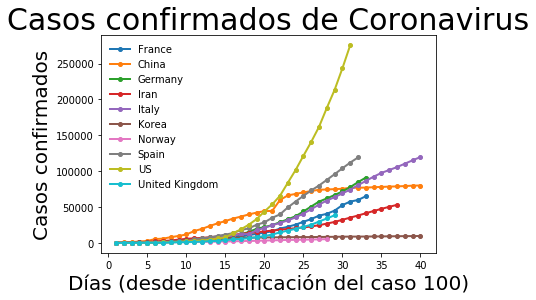

,France,China,Germany,Iran,Italy,"Korea, South",Norway,Spain,US,United Kingdom
36,NaN,78600.0,NaN,50468.0,101739.0,9332.0,NaN,NaN,NaN,NaN
37,NaN,78928.0,NaN,53183.0,105792.0,9478.0,NaN,NaN,NaN,NaN
38,NaN,79356.0,NaN,NaN,110574.0,9583.0,NaN,NaN,NaN,NaN
39,NaN,79932.0,NaN,NaN,115242.0,9661.0,NaN,NaN,NaN,NaN
40,NaN,80136.0,NaN,NaN,119827.0,9786.0,NaN,NaN,NaN,NaN


In [8]:
'''Vamos a hacer un gráfico para ver los casos confirmados (desde caso 100)'''

# Rellenar los valores menores de 100 por null
# PROBAR: https://stackoverflow.com/questions/46168450/replace-a-specific-range-of-values-in-a-pandas-dataframe
# data_drive_from100cases = data_time.mask(data_time < 100, 'null')
# data_drive_from100cases.head(2)

# Rellenar los valores menores de 100 por null
# PROBAR: https://stackoverflow.com/questions/46168450/replace-a-specific-range-of-values-in-a-pandas-dataframe
# data_drive_from100cases = data_time.mask(data_time < 100, 'null')
# data_drive_from100cases.head(2)

# Coger solo datos del último mes
data_time_30days = data_time[-200:]
# Si quiero quitar China: data_time_filter = data_time_filter.drop('China', axis=1)
data_time_30days.tail(2)

#Exporto los datos en diferentes arhcivos con casa país
for country in list_countries:
    dataX = data_time_30days[country]
    dataX = dataX[dataX > 100]
    dataX.to_csv('data_' + country + ".csv", index=False, header= country)

#Lista dataframes
dataframes_list = ['dataframe_France', 'dataframe_China', 'dataframe_Germany', 'dataframe_Iran', 'dataframe_Italy', 'dataframe_Korea', 'dataframe_Norway', 'dataframe_Spain', 'dataframe_US', 'dataframe_UnitedKingdom']
dataframes_list[1]

# Creamos los CSV
dataframe_France = pd.read_csv('data_France.csv')
dataframe_China = pd.read_csv('data_China.csv')
dataframe_Germany = pd.read_csv('data_Germany.csv')
dataframe_Iran = pd.read_csv('data_Iran.csv')
dataframe_Italy = pd.read_csv('data_Italy.csv')
dataframe_Korea = pd.read_csv('data_Korea, South.csv')
dataframe_Norway = pd.read_csv('data_Norway.csv')
dataframe_Spain = pd.read_csv('data_Spain.csv')
dataframe_US = pd.read_csv('data_US.csv')
dataframe_UnitedKingdom = pd.read_csv('data_United Kingdom.csv')

#Les añadimos NaN al final y reindexamos
new_index = np.arange(1,41)
dataframe_France = dataframe_France.reindex(new_index)
dataframe_China = dataframe_China.reindex(new_index)
dataframe_Germany = dataframe_Germany.reindex(new_index)
dataframe_Iran = dataframe_Iran.reindex(new_index)
dataframe_Italy = dataframe_Italy.reindex(new_index)
dataframe_Korea = dataframe_Korea.reindex(new_index)
dataframe_Norway = dataframe_Norway.reindex(new_index)
dataframe_Spain = dataframe_Spain.reindex(new_index)
dataframe_US = dataframe_US.reindex(new_index)
dataframe_UnitedKingdom = dataframe_UnitedKingdom.reindex(new_index)

# Lo ploteo
plt.plot(dataframe_France, label='France', marker='o', markersize=4, linewidth=2)
plt.plot(dataframe_China, label='China',marker='o', markersize=4, linewidth=2)
plt.plot(dataframe_Germany, label='Germany' ,marker='o', markersize=4, linewidth=2)
plt.plot(dataframe_Iran, label='Iran',marker='o', markersize=4, linewidth=2)
plt.plot(dataframe_Italy, label='Italy',marker='o', markersize=4, linewidth=2)
plt.plot(dataframe_Korea, label='Korea' ,marker='o', markersize=4, linewidth=2)
plt.plot(dataframe_Norway, label='Norway' ,marker='o', markersize=4, linewidth=2)
plt.plot(dataframe_Spain, label='Spain' ,marker='o', markersize=4, linewidth=2)
plt.plot(dataframe_US, label='US' ,marker='o', markersize=4, linewidth=2)
plt.plot(dataframe_UnitedKingdom, label='United Kingdom',marker='o', markersize=4, linewidth=2)

plt.legend(loc='upper left', frameon=False, fancybox=True)
plt.title('Casos confirmados de Coronavirus', {'fontsize': 30})

plt.xlabel("Días (desde identificación del caso 100)", {'fontsize': 20})
plt.ylabel("Casos confirmados", {'fontsize': 20})
plt.show()

#Juntar dataframes y Exportar CSV completo
data_drive_from100cases = dataframe_France.join([dataframe_China, dataframe_Germany, dataframe_Iran, dataframe_Italy, dataframe_Korea, dataframe_Norway, dataframe_Spain, dataframe_US,dataframe_UnitedKingdom])
data_drive_from100cases.to_csv('covid19_data_drive_from100.csv', sep = ';')
data_drive_from100cases.tail()

## Gráfico + CSV covid19_data_drive_days.csv

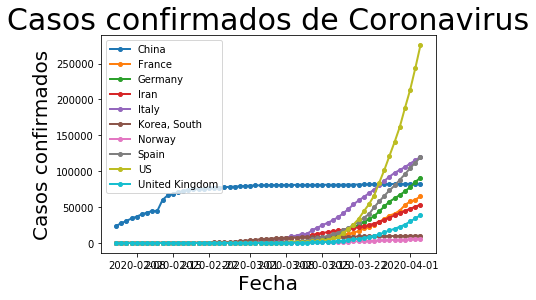

Country/Region,China,France,Germany,Iran,Italy,"Korea, South",Norway,Spain,US,United Kingdom
2020-03-30,82198.0,45170.0,66885.0,41495.0,101739.0,9661.0,4445.0,87956.0,161807.0,22453.0
2020-03-31,82279.0,52827.0,71808.0,44605.0,105792.0,9786.0,4641.0,95923.0,188172.0,25481.0
2020-04-01,82361.0,57749.0,77872.0,47593.0,110574.0,9887.0,4863.0,104118.0,213372.0,29865.0
2020-04-02,82432.0,59929.0,84794.0,50468.0,115242.0,9976.0,5147.0,112065.0,243453.0,34173.0
2020-04-03,82511.0,65202.0,91159.0,53183.0,119827.0,10062.0,5370.0,119199.0,275586.0,38689.0


In [9]:
# Coger solo datos de últimos 60 días
data_time_Xdays = data_time[-60:]
# Si quiero quitar China: data_time_filter = data_time_filter.drop('China', axis=1)
data_time_Xdays.tail(2)

'''Vamos a hacer un gráfico para ver los casos confirmados por fechas'''
plt.plot(data_time_Xdays, label='France', marker='o', markersize=4, linewidth=2)
plt.title('Casos confirmados de Coronavirus', {'fontsize': 30})
plt.xlabel("Fecha", {'fontsize': 20})
plt.ylabel("Casos confirmados", {'fontsize': 20})
plt.legend(list_countries)

plt.show()

#Exportar CSV por días progresivos
data_drive_lastX = data_time_Xdays.loc[:,list_countries]
data_drive_lastX.to_csv('covid19_data_drive_days.csv', sep = ';', encoding="utf-8")
data_drive_lastX.tail()


# Gráficos a nivel España

## Preparación general de datos

In [12]:
# Coger datos de España
# Data: https://github.com/michydev/Covid-19-Spain-API
data_ccaa = pd.read_json (r'https://api.chollx.es/coronavirus/ca', encoding= 'utf-8')
data_ccaa.set_index(["ccaa"], inplace = True, append = False, drop = True)

from datetime import datetime, timedelta
from datetime import date
date_today = date.today()
# date_today = date.today() - timedelta(days=1)
date_today = date_today.strftime('%d/%m')
print(date_today)

# Lista de todas las comunidades autónomos para luego cambiarles el nombre
list_ccaa = ['Andalucía','Aragón','Asturias','Baleares','Canarias','Cantabria','Castilla La Mancha','Castilla y León','Cataluña','Ceuta','C. Valenciana','Extremadura','Galicia','Madrid','Melilla','Murcia','Navarra','País Vasco', 'La Rioja']


04/04


## Gráfico + CSV: covid19_spain_ccaa_lineal.csv

In [47]:
from datetime import datetime
date_today_brut = data_ccaa.iloc[19,6]
date_today_evolution = date_today_brut[:8]
date_today_evolution_final = str(pd.Timestamp(date_today_evolution))
date_today_evolution_final = date_today_evolution_final[:10]

In [43]:
data_process = pd.read_csv("covid19_spain_ccaa_evolution2.csv", sep = ';', encoding="utf-8") #cambiar el data evolution
print('Si la sale TRUE, no se ha actualizado la tabla todavía >>>>>>>>' , data_ccaa.iloc[0,0] == data_process.iloc[0,-1])

Si la sale TRUE, no se ha actualizado la tabla todavía >>>>>>>> True


La columna ya está: no hacer merge


,2020-03-01,2020-03-02,2020-03-03,2020-03-04,2020-03-05,2020-03-06,2020-03-07,2020-03-08,2020-03-09,2020-03-10,...,2020-03-25,2020-03-26,2020-03-27,2020-03-28,2020-03-29,2020-03-30,2020-03-31,2020-04-01,2020-04-02,2020-04-03
Comunidades Autónomas,,,,,,,,,,,,,,,,,,,,,
Andalucía,6,12,13,13,13,21,21,21,54,71,...,3010,3406,3793,4277,4682,5405,5818,6392,6972,7374
Aragón,2,2,2,2,2,6,6,6,13,38,...,907,1116,1338,1592,1858,2078,2272,2491,2700,2889
Asturias,0,1,1,2,5,5,5,5,7,22,...,779,841,900,1004,1088,1158,1236,1322,1384,1433
Baleares,2,2,2,5,6,6,6,6,11,13,...,562,660,755,862,958,1000,1069,1131,1204,1257
Canarias,6,7,7,7,8,11,11,11,22,25,...,657,784,878,1025,1125,1204,1262,1380,1444,1490
Cantabria,0,10,10,10,10,10,10,10,12,12,...,510,671,810,937,1023,1100,1171,1213,1268,1321
Castilla La Mancha,0,3,7,12,13,15,15,15,26,39,...,2780,3383,3934,4512,5246,5858,6424,7047,7682,8523
Castilla y León,2,3,5,11,11,14,14,14,23,56,...,2940,3488,4132,4791,5414,5801,6211,6847,7355,7875
Cataluña,3,15,15,15,24,24,24,24,75,124,...,9937,11592,12940,14263,15026,16157,18773,19991,21804,23460


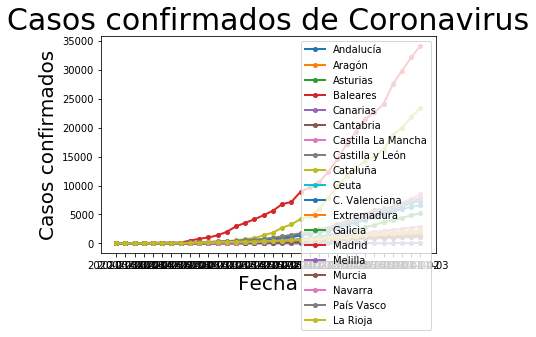

In [51]:
# Dataset de partida https://github.com/AlbertoCasasOrtiz/Coronavirus-Spain-Dataset

# Saco la última columna del dataframe habitual y la convierto en fecha
from datetime import datetime
date_today_brut = data_ccaa.iloc[19,6]
pd.to_datetime(date_today_brut)
date_today_evolution = pd.Timestamp(year=int(date_today_brut[6:10]), month=int(date_today_brut[3:5]), day=int(date_today_brut[1:2]), hour=12)
date_today_evolution_final = date_today_evolution.strftime('%Y-%m-%d')


#Hago copia de la base de datos para trabajar con ella
data_ccaa_evolution_last = data_ccaa.copy()
# Renombro la columna con la fecha y preparo la columna añadir nueva
data_ccaa_evolution_last.rename(columns = {'casos_totales': date_today_evolution_final}, index={'ccaa': 'Comunidades Autónomas'}, inplace = True)
data_ccaa_evolution_last = data_ccaa_evolution_last.iloc[0:19] #cojo las columnas que me interesan
data_ccaa_evolution_column = data_ccaa_evolution_last[date_today_evolution_final] #cojo sólo la columna de datos totales que acabo de renombrar


# Importo los últimos datos recogidos acumualdos anteriormente
data_process = pd.read_csv("covid19_spain_ccaa_evolution2.csv", sep = ';', encoding="utf-8") #cambiar el data evolution a 2 después de primera subida
data_process = data_process.set_index('Comunidades Autónomas')

# Hacer merge de ambos dataframes, con un condicional comprobando si es necesario
if data_process.columns[-1] == data_ccaa_evolution_last.columns[0]:
    print('La columna ya está: no hacer merge')
else:
    print('La última columna es diferente y no está: SE HACE MERGE')
    data_process = pd.merge(data_process,data_ccaa_evolution_column, left_index=True, right_index=True)
    
#Exportar a CSV
data_process.to_csv('covid19_spain_ccaa_evolution2.csv', sep = ';', encoding="utf-8", index=True, index_label='Comunidades Autónomas')
# print(data_process.head())

'''Vamos a hacer un gráfico para ver los casos confirmados por fechas'''
data_process_graphic= data_process.copy().transpose()
plt.plot(data_process_graphic, label='France', marker='o', markersize=4, linewidth=2)
plt.title('Casos confirmados de Coronavirus', {'fontsize': 30})
plt.xlabel("Fecha", {'fontsize': 20})
plt.ylabel("Casos confirmados", {'fontsize': 20})
plt.legend(list_ccaa)

# print(data_process.iloc[:, [-1,-2]].head())
data_process

## Gráfico + CSV: covid19_spain_ccaa.csv datos principales

In [44]:
# Poner bien los datos
data_ccaa_general = data_ccaa.copy()
data_ccaa_general = data_ccaa.iloc[0:19]
data_ccaa_general = data_ccaa_general.loc[:, ['casos_totales', 'fallecidos','hospitalizados','curados','nuevos_respecto_ayer']]
data_ccaa_general.rename(columns = {'CCAA':'Comunidades autónomas', 'casos_totales':'Casos totales' + ' - ' + date_today, 'fallecidos':'Fallecidos'+ ' - ' + date_today, 'hospitalizados':'Hospitalizados'+ ' - ' + date_today, 'nuevos_respecto_ayer':'Nuevos casos (24h)' + ' - ' + date_today, 'curados':'Curados' + ' - ' + date_today}, inplace = True)

#Exportar CSV
data_ccaa_general.to_csv('covid19_spain_ccaa.csv', sep = ';', encoding="utf-8")
data_ccaa_general.head(19)

,Casos totales - 04/04,Fallecidos - 04/04,Hospitalizados - 04/04,Curados - 04/04,Nuevos casos (24h) - 04/04
ccaa,,,,,
Andalucía,7374,376,3673,258,402
Aragón,2889,224,1431,378,189
Asturias,1433,70,702,154,49
Baleares,1257,69,587,375,53
Canarias,1490,73,605,102,46
Cantabria,1321,64,592,74,53
Castilla La Mancha,8523,0,316,0,0
Castilla y León,7875,0,271,0,0
Cataluña,23460,2335,17257,7849,1656


# Subir archivos a SERVIDOR desde FTP

In [47]:
import csv
from ftplib import FTP
from io import StringIO

In [48]:
# Ayuda: https://www.pythoncircle.com/post/668/uploading-a-file-to-ftp-server-using-python/

passw = pd.read_csv("pass.txt", sep = ',', encoding="utf-8")
host = "akakicreations.com"
username = passw.columns[0]
password = passw.columns[1]

ftp = FTP(host=host)

login_status = ftp.login(user=username, passwd=password)
print(login_status)

print(ftp.dir())
fp = open("covid19_data_drive_days.csv", 'rb')
ftp.storbinary('STOR %s' % os.path.basename("covid19_data_drive_days.csv"), fp, 1024)
fp = open("covid19_data_drive_from100.csv", 'rb')
ftp.storbinary('STOR %s' % os.path.basename("covid19_data_drive_from100.csv"), fp, 1024)
# fp = open("covid19_spain_ccaa.csv", 'rb')
# ftp.storbinary('STOR %s' % os.path.basename("covid19_spain_ccaa.csv"), fp, 1024)
# fp = open("covid19_spain_ccaa_evolution2.csv", 'rb')
# ftp.storbinary('STOR %s' % os.path.basename("covid19_spain_ccaa_evolution2.csv"), fp, 1024)
fp = open("covid19_data_drive_actual.csv", 'rb')
ftp.storbinary('STOR %s' % os.path.basename("covid19_data_drive_actual.csv"), fp, 1024)
fp = open("covid19_data_drive_resume.csv", 'rb')
ftp.storbinary('STOR %s' % os.path.basename("covid19_data_drive_resume.csv"), fp, 1024)
fp = open("diseno4_covid19.jpg", 'rb')
ftp.storbinary('STOR %s' % os.path.basename("diseno4_covid19.jpg"), fp, 1024)
fp.close()

230-OK. Current restricted directory is /
230 313 Kbytes used (0%) - authorized: 51200 Kb
drwxr-xr-x    2 akakicre   akakicre         4096 Apr  3 12:36 .
drwxr-xr-x    2 akakicre   akakicre         4096 Apr  3 12:36 ..
-rw-------    1 akakicre   akakicre            9 Apr  4 09:44 .ftpquota
-rw-r--r--    1 akakicre   akakicre       260069 Apr  3 12:34 Imagen_github.jpg
-rw-r--r--    1 akakicre   akakicre          284 Apr  4 09:44 covid19_data_drive_actual.csv
-rw-r--r--    1 akakicre   akakicre         4521 Apr  4 09:44 covid19_data_drive_days.csv
-rw-r--r--    1 akakicre   akakicre         2761 Apr  4 09:44 covid19_data_drive_from100.csv
-rw-r--r--    1 akakicre   akakicre          147 Apr  4 09:44 covid19_data_drive_resume.csv
-rw-r--r--    1 akakicre   akakicre          656 Apr  3 12:36 covid19_spain_ccaa.csv
-rw-r--r--    1 akakicre   akakicre         2982 Apr  3 12:36 covid19_spain_ccaa_evolution2.csv
-rw-r--r--    1 akakicre   akakicre        60965 Apr  4 09:44 diseno4_covid19.jpg

In [ ]:
# Pruebas
# Coger los datos de otra fuente:
data_ccaa_new = pd.read_csv(r'https://covid19tracking.narrativa.com/csv/confirmed.csv', encoding= 'utf-8')
data_ccaa_new = data_ccaa_new[data_ccaa_new['Country_EN'] == 'Spain']
data_ccaa_new = data_ccaa_new.drop(columns=['Country_EN', 'Country_ES'])
data_ccaa_new.sort_values('Region')